In [ ]:
from CellClass import MCImage, imread
from CellClass.Segment import Segmentation
from CellClass.process_masks import get_cell_patches
from CellClass.Preprocessing import illumination, apply_clahe
import matplotlib.pyplot as plt

CP = Segmentation("cellpose")

In [ ]:
%matplotlib inline
import numpy as np
img = imread("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/processed/S4_461.tif")
MCIm = MCImage(img, scheme="BGR")
MCIm.normalize()

MCIm.B = apply_clahe(MCIm.B)

_, res, o_dc = DC(MCIm.B, return_outline=True, image_mpp=.4, MCIm=MCIm)
_, res, o_cp = CP(MCIm.B, return_outline=True, MCIm=MCIm)

plt.rcParams['figure.figsize'] = 20,20

plt.imshow(o_dc)
plt.show()
plt.imshow(o_cp)
plt.show()

In [ ]:
from tqdm import tqdm
from CellClass import Analyse as an

import os

base = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/results/patches"
files = [os.path.join(base, x) for x in os.listdir(base) if "S29" in x]
print(files)

In [ ]:
patches = []
for f in tqdm(files):
    patches.extend(an.load_patches(f))

In [ ]:
nums, coords, ims, masks = [], [], [], []
for p in patches:
    num, coord, im, mask = *an.get_spots(p.R, p.mask), p.R, p.mask
    nums.append(num)
    coords.append(coord)
    ims.append(im)
    masks.append(mask)

In [ ]:
an.visualize(nums, coords, ims, masks)

In [ ]:
plt.rcParams["figure.figsize"] = 10, 10
an.get_stats(nums)

In [ ]:
an.visualize_nspots(nums, coords, ims, masks, 5)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from CellClass.utils import normalize_image
for n, p in enumerate(patches):
    plt.imshow(np.stack((p.R, np.zeros_like(p.R), p.B), axis=-1))
    plt.imshow(p.mask, alpha=0.1, cmap="gray")
    plt.show()
    
    dog = an.DoG(p.R)
    
    dog[~mask] = 0
    dog = normalize_image(dog)
    
    print(dog.max())
    
    plt.hist(dog[p.mask].ravel(), bins=255, density=True)
    plt.ylim([0,0.5])
    plt.show()
    if n==20:
        break

In [ ]:
def calc_p(l, h, im):
    return sum(im[(im > l) & (im < h)])/len(im)

def calc_w1(t, im,n=100):
    hv = np.linspace(0,t,n)
    return sum([calc_p(hv[i], hv[i+1], im) for i in  range(99)])
    
def calc_w2(t, im, n=100):
    hv = np.linspace(t,1,n)
    return sum([calc_p(hv[i], hv[i+1], im) for i in  range(99)])

def calc_u1(t, im, w1, n=100):
    hv = np.linspace(0,t,n)
    return sum([i*calc_p(hv[i], hv[i+1], im) for i in  range(99)])/w1

def calc_u2(t, im, w2, n=100):
    hv = np.linspace(t,1,n)
    return sum([i*calc_p(hv[i], hv[i+1], im) for i in range(99)])/w2

def calc_tstar(im):
    im = im.ravel()
    hv = np.linspace(0,1,100)
        
    l = []
    for i in range(1,99):
        
        t = hv[i]
        p = calc_p(t, hv[i+1], im)
        
        
        w1 = calc_w1(t, im)
        w2 = calc_w2(t, im)
        
        if w1 != 0 and w2 != 0:
            u1 = calc_u1(t, im, w1)
            u2 = calc_u2(t, im, w2)
            
            l.append((t, (1-p)*(w1*u1**2 + w2+u2**2)))
        
        
    return np.array(l)

In [ ]:
for n, p in enumerate(patches):
    plt.imshow(np.stack((p.R, np.zeros_like(p.R), p.B), axis=-1))
    plt.imshow(p.mask, alpha=0.1, cmap="gray")
    plt.show()
    
    dog = an.DoG(p.R)
    
    dog[~mask] = 0
    dog = normalize_image(dog)
    ts = calc_tstar(dog[mask])

    print(ts[:,1].max())

    plt.hist(dog[p.mask].ravel(), bins=255, density=True)
    plt.show()

    break


In [1]:
import os
import cv2
import numpy as np
from CellClass import evaluate_segmentation as eval
from natsort import natsorted
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm
import pandas as pd

base = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/testdata"
files = natsorted([x for x in os.listdir(base) if ".png" in x])

for file in files:
    if "SIMON" in file:
        eval._process_illustrator_output(os.path.join(base, file), os.path.join(base,"simon"))
    elif "FIKRET" in file:
        eval._process_illustrator_output(os.path.join(base, file), os.path.join(base,"fikret"))
        

  0%|          | 0/5 [00:00<?, ?it/s]

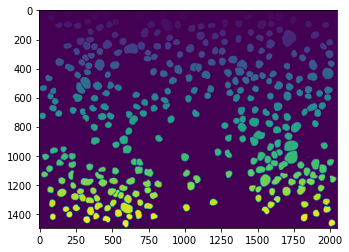

 20%|██        | 1/5 [00:03<00:15,  3.91s/it]

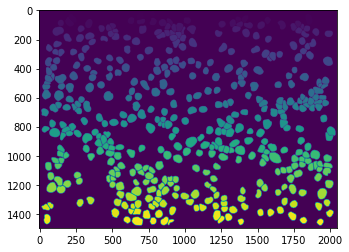

 40%|████      | 2/5 [00:08<00:13,  4.60s/it]

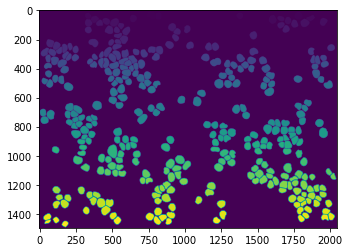

 60%|██████    | 3/5 [00:13<00:08,  4.34s/it]

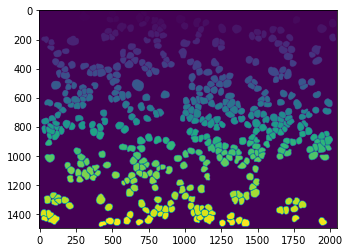

 80%|████████  | 4/5 [00:18<00:04,  4.69s/it]

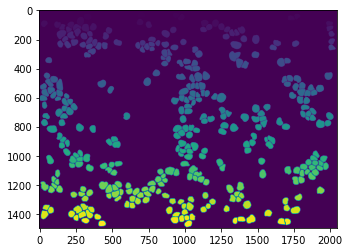

  0%|          | 0/1 [00:00<?, ?it/s]

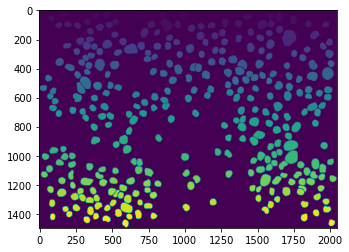

100%|██████████| 1/1 [00:03<00:00,  3.96s/it]


In [2]:
bases = ["/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/testdata/simon", "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/testdata/fikret"]

for base, observer in zip(bases, ["observer0", "observer1"]):
    files = natsorted([x for x in os.listdir(base) if ".png" in x])

    samples = []
    for file in tqdm(files):
        sample = file.split("-")[0]
        im = eval.remove_boarder(eval.load_segmentation(os.path.join(base, file)))
        samples.append({"name": sample, "im": im})
        plt.imshow(im); plt.show()

    locals()[observer] = pd.DataFrame(samples)

In [3]:
base = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/testdata/dapi"
files = natsorted([x for x in os.listdir(base) if ".tif" in x.lower()])

samples = []
for file in tqdm(files):
    sample = file.split(".")[0]
    im = cv2.imread(os.path.join(base, file), 0)
    samples.append({"name": sample, "im": im})

locals()["dapi"] = pd.DataFrame(samples)

100%|██████████| 5/5 [00:00<00:00, 16.41it/s]


In [4]:
from CellClass.Segment import Segmentation

CP = Segmentation("cellpose")

2022-06-24 14:10:46.071897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/simon_g/anaconda3/envs/CellClass/lib/python3.9/site-packages/cv2/../../lib64:
2022-06-24 14:10:46.071924: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
dfs = []
for _, row in dapi.iterrows():
    _, mask, o = CP(row.im, return_outline=True)
    mask = eval.remove_boarder(mask)
    dfs.append({"name": row["name"], "dapi": row.im, "im": mask})
    

In [6]:
predictions = pd.DataFrame(dfs)

DAPI_0


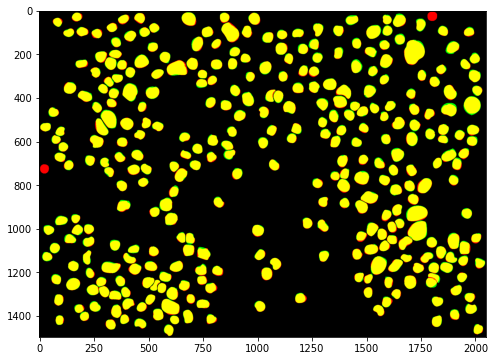

100%|██████████| 330/330 [00:04<00:00, 76.20it/s]


False Positives: 0
False Negatives: 2


100%|██████████| 328/328 [00:30<00:00, 10.78it/s]


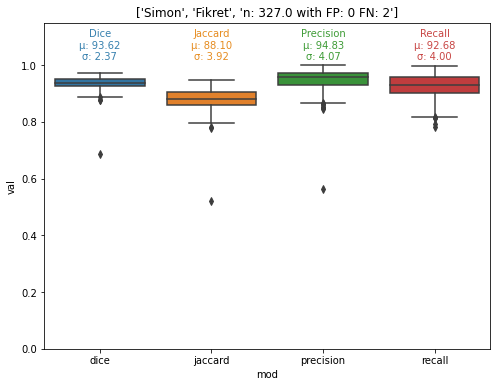

DAPI_0


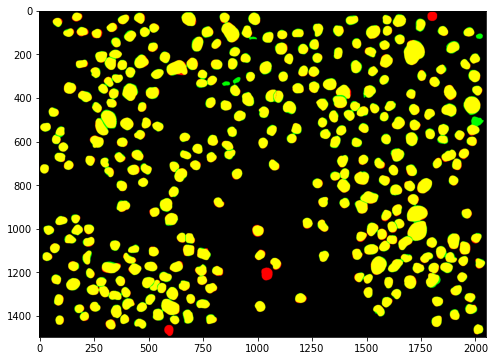

100%|██████████| 330/330 [00:04<00:00, 76.54it/s]


False Positives: 5
False Negatives: 3


100%|██████████| 327/327 [00:30<00:00, 10.62it/s]


DAPI_1


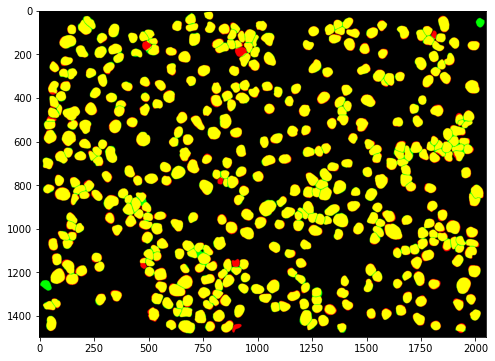

100%|██████████| 444/444 [00:06<00:00, 69.01it/s]


False Positives: 2
False Negatives: 6


100%|██████████| 438/438 [00:42<00:00, 10.40it/s]


DAPI_2


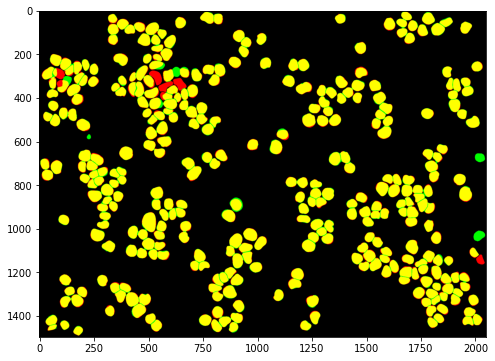

100%|██████████| 348/348 [00:04<00:00, 75.82it/s]


False Positives: 4
False Negatives: 4


100%|██████████| 343/343 [00:32<00:00, 10.53it/s]


DAPI_3


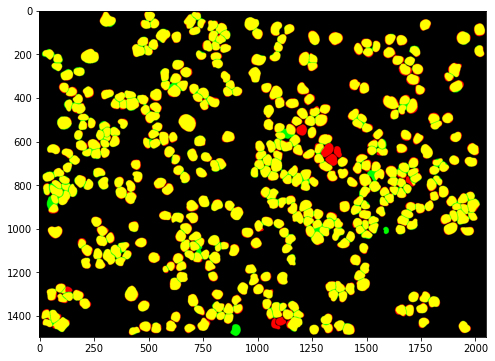

100%|██████████| 452/452 [00:05<00:00, 79.21it/s]


False Positives: 3
False Negatives: 7


100%|██████████| 444/444 [00:43<00:00, 10.28it/s]


DAPI_4


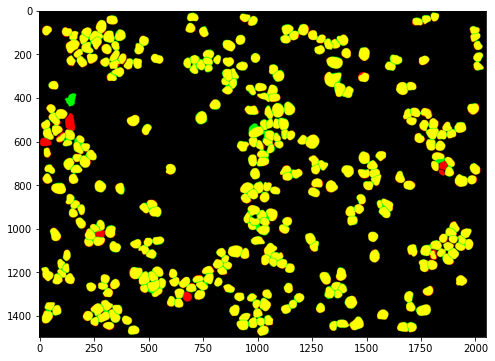

100%|██████████| 357/357 [00:06<00:00, 58.41it/s]


False Positives: 1
False Negatives: 6


100%|██████████| 351/351 [00:33<00:00, 10.42it/s]


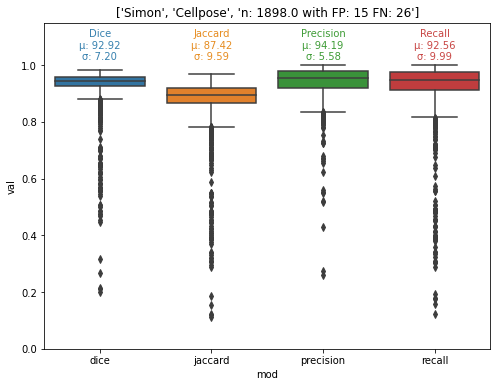

DAPI_0


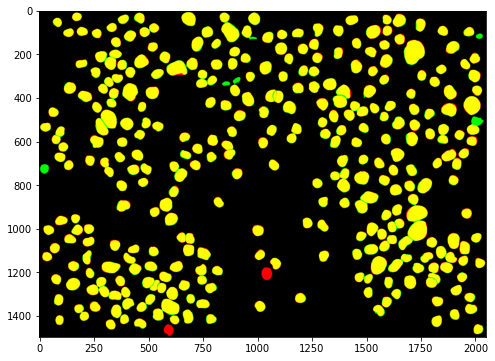

100%|██████████| 335/335 [00:04<00:00, 76.50it/s]


False Positives: 6
False Negatives: 2


100%|██████████| 327/327 [00:31<00:00, 10.43it/s]


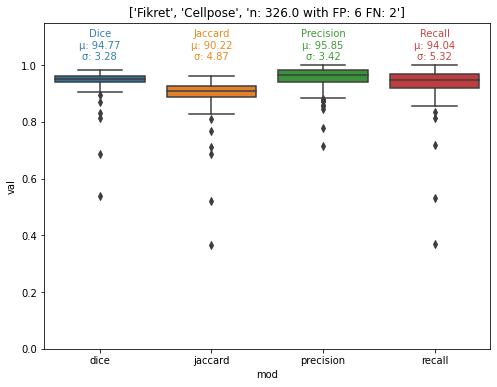

In [23]:
import importlib
importlib.reload(eval)

def compare_segmentations(df0, df1, title):

    rets = []
    fps = 0
    fns = 0
    for _, row in df0.iterrows():
        if any(df1['name'].str.contains(row["name"])):
            print(row["name"])
            seg0 = np.copy(row["im"])
            seg1 = np.copy(df1[df1["name"]==row["name"]].im.item())
            plt.imshow(eval.additive_blend(seg0, seg1));plt.show()
            ret, fp, fn = eval.compare_segmentations(seg0, seg1)
            rets.extend(ret)
            fps += fp
            fns += fn
            
    df = pd.DataFrame(rets)
    d = []
    for n in natsorted(df["mod"].unique()):
        tmp = df[df["mod"] == n]
        d.append({
            "mean": tmp.val.mean(),
            "std": tmp.val.std(),
            "measure": n,
            })
                
    plt.rcParams["figure.figsize"] = 8,6
    ax = sb.boxplot(x="mod", y="val", data=df)
    ax.set_ylim(0, 1.15)

    for info, n, c, val in zip(d, np.linspace(0,3,4), ["#3680AE", "#E68C20", "#3F9C37", "#C84644"], [f"Dice", f"Jaccard",f"Precision",f"Recall"]):
        plt.text(n, 1.07, f"{val}\nµ: {info['mean']*100:.2f}\nσ: {info['std']*100:.2f}", ha="center", va="center", c=c)
       
    ax.set_title([*title, f"n: {len(rets)/4} with FP: {fps} FN: {fns}"])  
    plt.show()   
                
compare_segmentations(observer0, observer1, ["Simon", "Fikret"])  
compare_segmentations(observer0, predictions, ["Simon", "Cellpose"])  
compare_segmentations(observer1, predictions, ["Fikret", "Cellpose"])  

